# NN & CNN
In this laboratory we will be looking at Fully Connected Neural Networks and Convolutional Neural Networks using Pytorch.

Make sure to change the Colab Runtime to GPU for this laboratory.

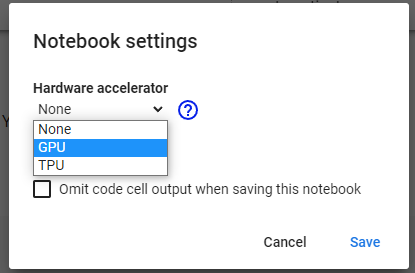

# Load and Visualize the [Data](https://pytorch.org/vision/stable/datasets.html) - [MNIST Dataset](https://en.wikipedia.org/wiki/MNIST_database)
Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the batch_size if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [16]:
# import libraries
import torch
import numpy as np
cuda = torch.device('cuda')
import statistics

In [17]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0], [1])
])

valid_transform = train_transform

train_set = MNIST('./data/mnist', train=True, download=True, transform=train_transform)
valid_set = MNIST('./data/mnist', train=False, download=True, transform=valid_transform)

In [18]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

### Visualize a Batch of Training Data
The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

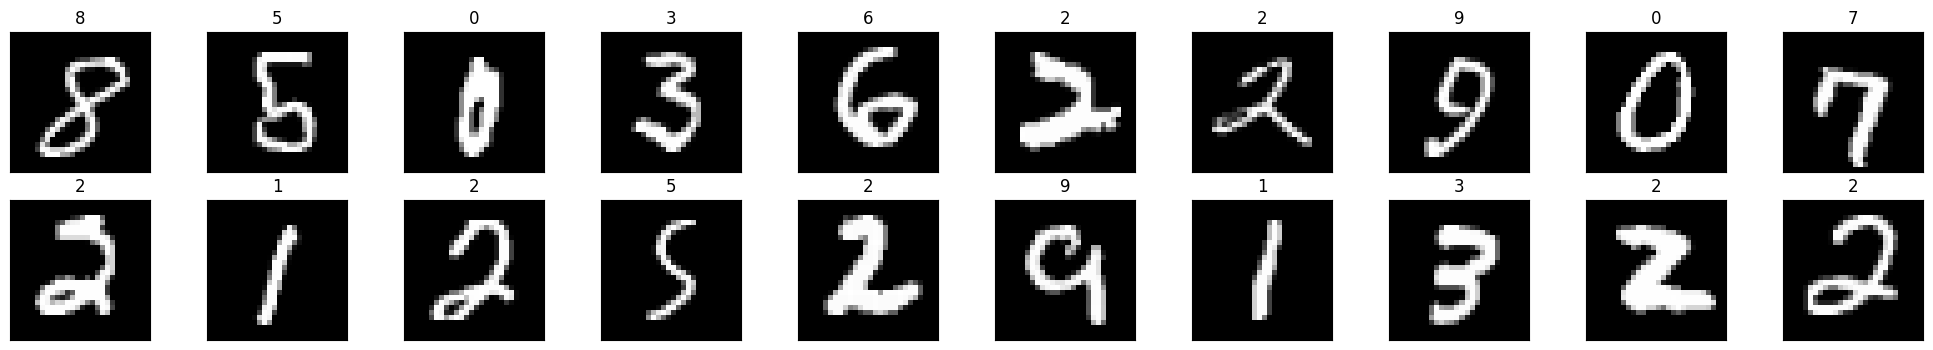

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images - 20 images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels for 20 images
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

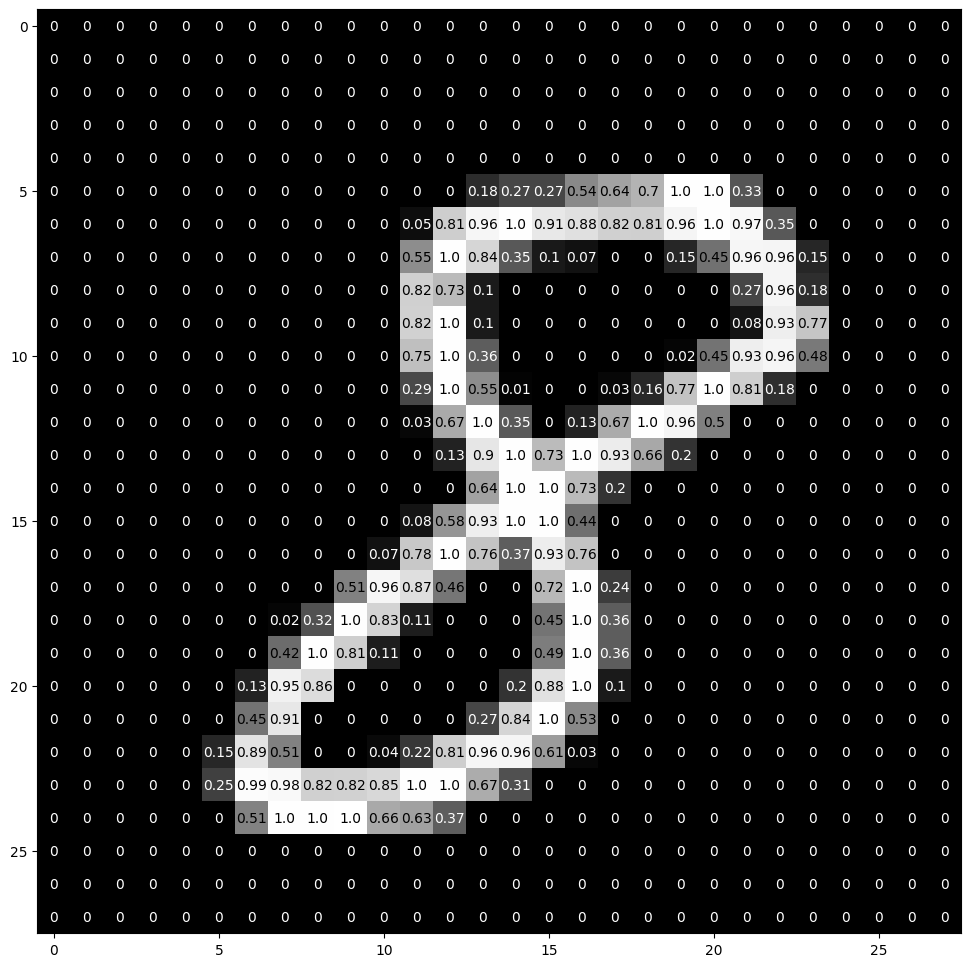

In [20]:
img = np.squeeze(images[0]) # Take the 1st image from the dataset

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Define the [Network Architecture](https://pytorch.org/docs/stable/nn.html)
The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.



### Simple Neural Network

We will start with the basic example of a shallow NN: an input layer, two hidden layers and the output layer. We'll use dropout to avoid overfitting.

Each MNIST training example consists of a 28x28 pixels image in grayscale (1 channel), that is turned into a 784-elements vector. The input layer has 784 neurons, we have a hidden layer of 64 neurons and a second hidden layer of 32 neurons. The output layer has 1 neuron for each one of the classes, in this case 10 neurons (10 digits - 0, 1 2, 3, etc).

To implement our neural network, we create the class **BasicNN** and inherit the methods and properties from the Module class (**nn.Module**):

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class BasicNN(nn.Module):

    def __init__(self, input_size, num_classes):

        super(BasicNN, self).__init__()
        # number of hidden nodes in each layer
        hidden_size_1 = 64
        hidden_size_2 = 32

        # linear layer (784 -> hidden_size_1)
        self.fc1 = nn.Linear(input_size, hidden_size_1)

        # linear layer (hidden_size_1 -> hidden_size_2)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)

        # linear layer (hidden_size_2 -> num_classes)
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.drop = nn.Dropout(0.2)



    def forward(self, x):
        # flatten image input
        x = x.reshape(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.drop(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.drop(x)
        # add output layer
        x = self.fc3(x)
        return x


# initialize the NN
cuda = torch.device('cuda')
model = BasicNN(input_size=28 * 28, num_classes=10)
model.to(cuda)
print(model)

AssertionError: Torch not compiled with CUDA enabled

 ### Train the Network
The steps for training/learning from a batch of data are described in the comments below:

* Clear the gradients of all optimized variables
* Forward pass: compute predicted outputs by passing inputs to the model
* Calculate the loss
* Backward pass: compute gradient of the loss with respect to model parameters
* Perform a single optimization step (update weights)
* Update average training loss

The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [ ]:
def train(model, loss_fn, optimizer):

    # https://pytorch.org/docs/stable/nn.html#torch.nn.Module.train
    # set the module in training mode
    model.train()

    train_batch_losses = []

    for batch, labels in train_loader:

        #send the training data to the GPU
        batch = batch.to(cuda)
        labels = labels.to(cuda)

        #set all gradient to zero
        optimizer.zero_grad()

        #forward propagation
        y_pred = model(batch)

        #calculate loss
        loss = loss_fn(y_pred, labels)

        #backpropagation
        loss.backward()

        #update the parameters (weights and biases)
        optimizer.step()

        train_batch_losses.append(float(loss))

        mean_loss = statistics.mean(train_batch_losses)

    return mean_loss

In [ ]:
def validate(model, loss_fn, optimizer):

    # set the model in validation mode
    model.eval()

    # save predictions for later
    predictions = []

    # stop tracking the parameters for backpropagation
    with torch.no_grad():

        validation_batch_losses = []

        for batch, labels in valid_loader:

            # send the validation data to the GPU
            batch = batch.to(cuda)
            labels = labels.to(cuda)

            # forward propagation
            labels_pred = model(batch)

            # calculate the loss
            loss = loss_fn(labels_pred, labels)

            validation_batch_losses.append(float(loss))

            mean_loss = statistics.mean(validation_batch_losses)

    return mean_loss



In [ ]:
def accuracy(model, loader):
    correct = 0
    total = 0

    # set the model in validation mode to deactivate the dropout layer
    model.eval()

    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)

            labels_pred = model(batch)

            _, predicted = torch.max(labels_pred.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            return (100 * correct / total)

In [ ]:
def training_stats(train_loss, train_accuracy, val_loss, val_accuracy):
    print(('training loss: {:.3f} '
           'training accuracy: {:.2f}% || '
           'val. loss: {:.3f} '
           'val. accuracy: {:.2f}%').format(train_loss, train_accuracy,
                                            val_loss, val_accuracy))

### Specify [Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](https://pytorch.org/docs/stable/optim.html)
It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [ ]:
# initialize the NN
cuda = torch.device('cuda')
model = BasicNN(input_size=28 * 28, num_classes=10)
model.to(cuda)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 10

train_losses = []
valid_losses = []

for epoch in range(0, epochs):

    print('Epoch number ', epoch + 1)

    train_loss = train(model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(model, train_loader)

    valid_loss = validate(model, loss_fn, optimizer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(model, valid_loader)

    training_stats(train_loss, train_accuracy, valid_loss, valid_accuracy)



### Visualize Sample Test Results
This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

In [ ]:
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images = images.to(cuda)
labels = labels.to(cuda)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.detach().cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# CNNs

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size)
```

num_in_channels is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

num_out_channels is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

So for instance, if we have an RGB image and we are going to apply 32 filters of 3x3:



```
torch.nn.Conv2d(3, 32, 3)
```





## A Simple Convolutional Neural Network

In our convnet we'll use the next structure:

*input -> convolution -> pooling-> convolution -> pooling -> convolution* (convolutional base)

*fully connected -> fully connected -> output*

In [ ]:
class BasicCNN(nn.Module):

    def __init__(self, num_channels, num_classes):
        super(BasicCNN, self).__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # for grayscale (e.g. 28 x 28 x 1) image inputs we have 1 input channel
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3*3*64, 64, bias=True)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, X):
        x = F.relu(self.conv1(X))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Input Image**

28 x 28 x 1 pixel values

**Convolution #1**

32 kernels of 3x3; *Width/Height:* (28 - 3 + 2x0) / 1 + 1 = 26; *Output dimensions:* (32, 26, 26)

**Max Pooling #1**

filter size = 2, stride = 2; *Width/Height:* (26 - 2) / 2 + 1 = 13; *Output dimensions:* (32, 13, 13)

**Convolution #2**

64 kernels of 3x3; *Width/Height:* (13 - 3 + 2x0) / 1 + 1 = 11; *Output dimensions:* (64, 11, 11)

**Max Pooling #2**

filter size = 2, stride = 2; *Width/Height:* (11 - 2) / 2 + 1 = 5; *Output dimensions:* (64, 5, 5)

**Convolution #3**

64 kernels of 3x3; *Width/Height:* (5 - 3 + 2x0) / 1 + 1 = 3; *Output dimensions:* (64, 3, 3)

So at the end of the last convolutional layer we get a tensor of dimension (64, 3, 3). And since now we are going to feed it to out fully connected classifier, we need to convert it into a vector, and for that we use the reshape method:



```
x = x.reshape(-1, 3*3*64)
```

### Useful output size calculation
**Convolution & Pooling**

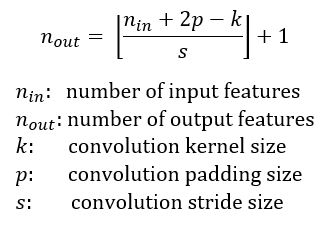

In [ ]:
cuda = torch.device('cuda')

model = BasicCNN(1, 10)
model.to(cuda)

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()
epochs = 10

train_losses = []
valid_losses = []

for epoch in range(0, epochs):

    print('Epoch number ', epoch + 1)

    train_loss = train(model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(model, train_loader)

    valid_loss = validate(model, loss_fn, optimizer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(model, valid_loader)

    training_stats(train_loss, train_accuracy, valid_loss, valid_accuracy)



In [ ]:
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images = images.to(cuda)
labels = labels.to(cuda)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.detach().cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Classifying [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10) dataset using CNNs


In [ ]:
from torchvision.datasets import CIFAR10

dataset_transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = CIFAR10('./cifar10', train=True, download=True, transform=dataset_transform)
valid_set = CIFAR10('./cifar10', train=False, download=True, transform=dataset_transform)

print(train_set.data.shape)
print(valid_set.data.shape)

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

In [ ]:
class BasicCNN(nn.Module):

    def __init__(self, num_channels, num_classes):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*4*64, 64, bias=True)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, X):
        x = F.relu(self.conv1(X))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch.optim as optim

cuda = torch.device('cuda')
model = BasicCNN(3, 10)
model.to(cuda)

optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()
epochs = 20

train_losses = []
valid_losses = []

best_valid_acc = 0

for epoch in range(0, epochs):

    print('Epoch number ', epoch + 1)

    train_loss = train(model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(model, train_loader)

    valid_loss = validate(model, loss_fn, optimizer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(model, valid_loader)
    if best_valid_acc < valid_accuracy:
        best_valid_acc = valid_accuracy

    training_stats(train_loss, train_accuracy, valid_loss, valid_accuracy)
print('Best validation accuracy', best_valid_acc)

In [ ]:
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images = images.to(cuda)
labels = labels.to(cuda)

print(images[0].shape)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.detach().cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    # img = img.swapaxes(1,2)
    ax.imshow(images[idx].swapaxes(0,2).swapaxes(0,1))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### CIFAR10 classes
```
airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9
```



# Assignments

1. Create a **Fully Connected Neural Network** yourselves that obtains more than **95%** accuracy on **MNIST** data **after 10 epochs**

2. Create a **Convolutional Neural Network** yourselves that obtains more than **67%** accuracy on **CIFAR10** data **after 10 epochs**

Ideas: dropout layers, wider networks, deeper networks, imitating famous network architectures.